In [1]:
import os, sys, csv, gzip
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy import io

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
%matplotlib inline

from plots import COLORS10, enlarge_tick_fontsize
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.cross_validation import (StratifiedKFold, cross_val_score)
from sklearn.metrics import *
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble
from sklearn.pipeline import Pipeline
import xgboost as xgb

# 1. Prepare the gene/feature attribute matrices and target class to for supervised machine learning

Load known Barrier Complex Genes components from file

In [2]:
df_labels = pd.read_csv('data/components.csv')
print df_labels.shape
df_labels.head()

(63, 1)


,Official Symbol
0,S100A10
1,S100A11
2,TCHHL1
3,TCHH
4,RPTN


These files below were downloaded from [Harmonizome](http://amp.pharm.mssm.edu/Harmonizome/) as the features for genes to predict whether they are adhesome components. 

There are two types datasets: continues and binary. Continues datasets were standardized.    

In [3]:
filenames = [
        #'InterPro_gene_attribute_matrix.txt.gz', 
        'ENCODE-TF_gene_attribute_matrix.txt.gz',
        'CCLE-GE_gene_attribute_matrix_standardized.txt.gz',
        'Allen-adult-brain_gene_attribute_matrix_standardized.txt.gz',
        'Allen-dev-brain_gene_attribute_matrix_standardized.txt.gz'
    ]
basenames = [f.split('_')[0] for f in filenames]
are_continues = ['_standardized' in f for f in filenames]

In [4]:
def read_gene_attribute_matrix(fn):
	'''
	Reads a gzipped file downloaded from Harmonizome into a pandas.DataFrame,
	with GeneSym as index. 
	'''
	with gzip.open(fn) as f:
		reader = csv.reader(f, delimiter='\t')
		header = reader.next()
		header[0] = 'GeneSym'
		# Skip line 2, 3
		reader.next()
		reader.next()

		# Remove the second and third columns which are meta data for GeneSym
		header[1:3] = []

		i = 0
		df = []
        
		for row in reader:
			row[1:3] = []
			row[1:] = map(float, row[1:])
			df.append(dict(zip(header, row)))
			i += 1
			if i % 2000 == 0:
				print i
		df = pd.DataFrame().from_records(df)[header]
		df.set_index('GeneSym', inplace=True, verify_integrity=True)

#  		if '_standardized' in fn: # continues
# 			for row in reader:
# 				row[1:3] = []
# 				row[1:] = map(float, row[1:])
# 				df.append(dict(zip(header, row)))
# 				i += 1
# 				if i % 2000 == 0:
# 					print i
# 			df = pd.DataFrame().from_records(df)[header]
# 			df.set_index('GeneSym', inplace=True, verify_integrity=True)
					
# 		else: # convert values to int and make sparse df
# 			for row in reader:
# 				row[1:3] = []
# 				row[1:] = map(lambda x: int(float(x)), row[1:])

# 				d = {h: v for h, v in zip(header, row) if v != 0}
# 				df.append(d)
# 				i += 1
# 				if i % 2000 == 0:
# 					print i
# 			df = pd.DataFrame().from_records(df)[header]\
# 				.set_index('GeneSym', verify_integrity=True)\
# 				.to_sparse(fill_value=0)
		
	return df

In [5]:
## Parse data files downloaded from Harmonizome 
dfs = []
for fn in filenames:
    df = read_gene_attribute_matrix('data/%s' % fn)
    print fn, df.shape
    dfs.append(df)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
ENCODE-TF_gene_attribute_matrix.txt.gz (22819, 181)
2000
4000
6000
8000
10000
12000
14000
16000
18000
CCLE-GE_gene_attribute_matrix_standardized.txt.gz (18046, 1037)
2000
4000
6000
8000
10000
12000
14000
16000
Allen-adult-brain_gene_attribute_matrix_standardized.txt.gz (17979, 414)
2000
4000
6000
8000
10000
12000
14000
Allen-dev-brain_gene_attribute_matrix_standardized.txt.gz (15072, 524)


In [6]:
#dfs

In [7]:
#dfs[dfs== np.nan] = str(0.0)


In [8]:
#df_labels[y>0]

In [9]:
## INNER JOIN all feature dfs 
df_joined = reduce(lambda a, b: pd.merge(a, b, left_index=True, right_index=True, how='outer'), 
           dfs)
print df_joined.shape

(24268, 2156)


In [10]:
df_joined.replace(np.nan, 0.0, inplace=True)
df_joined.replace(np.inf, 0.0, inplace=True)

In [11]:
#'FLG' in df_joined.index.sort_values()

In [12]:
## Create y 
RNG = 2016
y = np.in1d(df_joined.index, df_labels['Official Symbol']).astype(np.int8)
print y.sum()
## Make CV
cv = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=RNG)
## Export y
df_labels = pd.DataFrame({'y': y, 'GeneSym': df_joined.index}).set_index('GeneSym')
print df_labels.shape
df_labels.to_csv('data/Barrier_Complex_Genes.csv')
df_labels.head()

62
(24268, 1)


,y
GeneSym,
A1BG,0
A1BG-AS1,0
A1CF,0
A2M,0
A2M-AS1,0


In [13]:
## Keep only the shared genes across the 4 datasets
dfs = [df.ix[df_joined.index] for df in dfs]

In [14]:
## Export processed matrices in dfs
feature_names = {} # To store feature names
i = 0
# for basename, df in zip(basenames, dfs):
#     feature_names[basename] = df.columns.tolist()
#     if are_continues[i]:
#         np.save('data/%s_shared' % basename, df.values)
#     else: # sparse matrix
#         io.mmwrite('data/%s_shared.mtx' % basename, sp.csr_matrix(df.values))
#     i += 1

for basename, df in zip(basenames, dfs):
    feature_names[basename] = df.columns.tolist()

    np.save('data/%s_shared' % basename, df.values)


del df_joined
del dfs, df

# 2. Load preprocessed matrices and perform classifications

In [15]:
# Load from matrices files generated above
Xs = []
# for i, basename in enumerate(basenames):
#     if are_continues[i]:
#         Xs.append(np.load('data/%s_shared.npy' % basename))
#     else:
#         Xs.append(io.mmread('data/%s_shared.mtx' % basename))#.tocsr())

for i, basename in enumerate(basenames):
    Xs.append(np.load('data/%s_shared.npy' % basename))

df_labels = pd.read_csv('data/Barrier_Complex_Genes.csv')
y = df_labels['y'].values
ratio = float(np.sum(y == 0)) / np.sum(y==1)
print 'Number of known P53 components: %d' % y.sum()
print 'Ratio of negative labels over positive labels: %.4f' % ratio

Number of known P53 components: 62
Ratio of negative labels over positive labels: 390.4194


Perform dimentionality reduction using `TruncatedSVD` for all the matrices

In [16]:
#Xs[1] = np.nan_to_num(Xs[1])

In [17]:
Xs

[array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  1.,  1., ...,  0.,  1.,  0.],
        [ 1.,  1.,  1., ...,  0.,  1.,  0.],
        [ 1.,  0.,  1., ...,  0.,  1.,  0.]]),
 array([[-0.159268, -0.159268, -0.37953 , ...,  0.141982,  0.124178,
          0.359077],
        [-0.196666, -0.196666, -0.171546, ..., -0.063259,  0.78517 ,
         -0.831617],
        [ 0.603561,  0.603561, -0.47043 , ..., -0.136257,  0.316388,
          0.28039 ],
        ..., 
        [-0.552704, -0.552704, -0.315278, ...,  0.065803, -0.310582,
          0.079831],
        [-0.023427, -0.023427, -0.68874 , ...,  1.111356, -0.391881,
         -0.534035],
        [-0.466249, -0.466249, -0.589432, ..., -0.196899, -0.212646,
         -0.127792]]),
 array([[ 0.202047,  0.176362,  0.213028, ..., -0.183894, -0.294889,
         -0.934304],
        [      nan,       nan,       nan, ...,       nan,       nan,

In [18]:
all_loadings = [] # collect loading matrices from SVD
for i, basename in enumerate(basenames):
    print i
    svd = TruncatedSVD(n_components=60, random_state=RNG)
    Xs[i] = np.nan_to_num(Xs[i])
    Xs[i] = svd.fit_transform(Xs[i])
    all_loadings.append(svd.components_)    

X_combined = np.hstack(Xs)

0
1
2
3


In [19]:
## Helper functions for evaluating classifiers
def cross_val_predictions(est, X, y, cv):
	'''to get out-of-sample predictions and scores'''
	y_preds = np.zeros(y.shape)
	y_probas = np.zeros(y.shape)
	for train_idx, valid_idx in cv:
		print X[train_idx].shape, y[train_idx].shape
		est.fit(X[train_idx], y[train_idx])
		y_preds[valid_idx] = est.predict(X[valid_idx])
		y_probas[valid_idx] = est.predict_proba(X[valid_idx])[:,1]
	return y_preds, y_probas


def plot_roc(ests, Xs, y, cv, ax, colors=None, labels=None):
	all_labels = []
	total = len(labels)

	if type(ests) == list and type(Xs) != list:
		total = len(ests)
		Xs = [Xs]*total
	elif type(ests) != list and type(Xs) == list:
		ests = [ests]*total
	
	for i in range(total):
		X = Xs[i]
		est = ests[i]
		
		label = labels[i]
		color = colors[i]
		all_labels.extend([label] * len(cv))

		y_preds, y_probas = cross_val_predictions(est, X, y, cv)
		fpr, tpr, _ = roc_curve(y, y_probas)
		score = auc(fpr, tpr)
		ax.plot(fpr, tpr, label=label + ' (AUC=%.3f)' % score, color=color, lw=2)

	ax.set_xlabel('False Positive Rate', fontsize=16)
	ax.set_ylabel('True Positive Rate', fontsize=16)

	enlarge_tick_fontsize(ax, 12)
	ax.legend(loc='lower right')
	return

Estimate the number of rounds of boosting using early stopping for a single feature matrix InterPro: The boosting classifier will stop if the validation score does not improve in 50 rounds.

In [20]:
dtrain = xgb.DMatrix(Xs[0], label=y)

param = {
    'max_depth':10, 'eta':0.05, 'silent':1, 'objective':'binary:logistic',
    'subsample': 0.4, 'colsample_bytree': 0.6,
    'min_child_weight': 50,
    'scale_pos_weight': ratio,
    'nthread': 6
}

num_round = 5000
scores = xgb.cv(param, dtrain, num_round, early_stopping_rounds=50, metrics='auc', seed=RNG, verbose_eval=10)

print scores.tail()


[0]	train-auc:0.861439+0.0213104	test-auc:0.735561+0.0346839
[10]	train-auc:0.986401+0.00484127	test-auc:0.796478+0.0292095
[20]	train-auc:0.992124+0.00203797	test-auc:0.802545+0.00580475
[30]	train-auc:0.995057+0.000755581	test-auc:0.840382+0.0133088
[40]	train-auc:0.99564+0.000808074	test-auc:0.843538+0.0102185
[50]	train-auc:0.996261+0.000534817	test-auc:0.845308+0.0105306
[60]	train-auc:0.996955+0.00031438	test-auc:0.849241+0.0100449
[70]	train-auc:0.997465+0.000303909	test-auc:0.850896+0.00904656
[80]	train-auc:0.997713+0.000280286	test-auc:0.849494+0.0176356
[90]	train-auc:0.997849+0.00037915	test-auc:0.848392+0.00810172
[100]	train-auc:0.997917+0.000376755	test-auc:0.840819+0.00920526
[110]	train-auc:0.998161+0.000317871	test-auc:0.841604+0.010695
[120]	train-auc:0.998271+0.00035264	test-auc:0.841988+0.0107168
[130]	train-auc:0.998336+0.000299384	test-auc:0.839833+0.00971854
    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
80       0.849494      0.017636        0.9

Estimate the number of rounds of boosting using early stopping for the combined feature matrix.

In [21]:
dtrain = xgb.DMatrix(X_combined, label=y)

param = {
    'max_depth':12, 'eta':0.05, 'silent':1, 'objective':'binary:logistic',
    'subsample': 0.4, 'colsample_bytree': 0.4,
    'min_child_weight': 50,
    'scale_pos_weight': ratio,
    'nthread': 6
}

num_round = 5000
scores = xgb.cv(param, dtrain, num_round,
    early_stopping_rounds=50,
    metrics='auc', seed=RNG,
    verbose_eval=10)

print scores.tail()


[0]	train-auc:0.857427+0.0180749	test-auc:0.736712+0.0312056
[10]	train-auc:0.996253+0.000699343	test-auc:0.754397+0.0313153
[20]	train-auc:0.999082+0.00029153	test-auc:0.829695+0.00378061
[30]	train-auc:0.999466+0.000270072	test-auc:0.865845+0.0112875
[40]	train-auc:0.999688+0.000163195	test-auc:0.871495+0.0109939
[50]	train-auc:0.999831+9.41288e-05	test-auc:0.865135+0.0157055
[60]	train-auc:0.999893+8.65114e-05	test-auc:0.868585+0.02814
[70]	train-auc:0.999927+2.56298e-05	test-auc:0.872204+0.0343321
[80]	train-auc:0.999939+3.97185e-05	test-auc:0.879977+0.0263666
[90]	train-auc:0.999956+3.36749e-05	test-auc:0.889883+0.0166789
[100]	train-auc:0.999962+3.02251e-05	test-auc:0.883935+0.0178355
[110]	train-auc:0.999963+2.80159e-05	test-auc:0.886791+0.0081723
[120]	train-auc:0.999969+2.2291e-05	test-auc:0.885636+0.00860107
[130]	train-auc:0.999967+2.31132e-05	test-auc:0.885066+0.00811844
[140]	train-auc:0.999964+2.54689e-05	test-auc:0.888323+0.00860838
    test-auc-mean  test-auc-std  train

Plot the ROC curves to evaluate the predictive performance of the GBM classifiers

(16178, 60) (16178,)
(16178, 60) (16178,)
(16180, 60) (16180,)
(16178, 60) (16178,)
(16178, 60) (16178,)
(16180, 60) (16180,)
(16178, 60) (16178,)
(16178, 60) (16178,)
(16180, 60) (16180,)
(16178, 60) (16178,)
(16178, 60) (16178,)
(16180, 60) (16180,)
(16178, 240) (16178,)
(16178, 240) (16178,)
(16180, 240) (16180,)


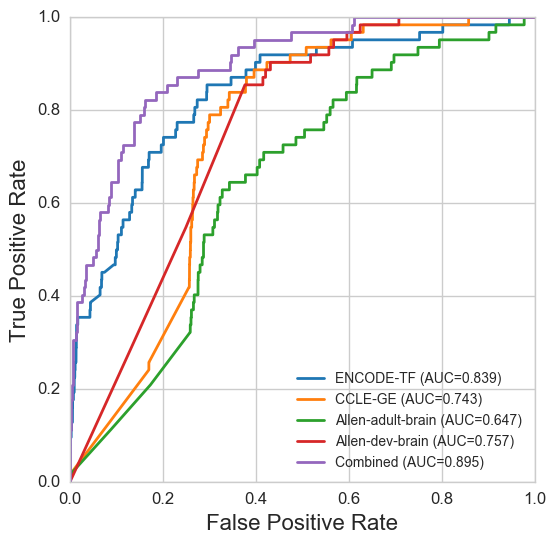

In [22]:
Xs.append(X_combined)
basenames.append('Combined')

# optimized GBM classifiers
xgbc = xgb.XGBClassifier(seed=RNG, n_estimators=39, learning_rate=0.05,
    max_depth=10, colsample_bytree=0.6, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=6, silent=True, scale_pos_weight=ratio)

xgbc2 = xgb.XGBClassifier(seed=RNG, n_estimators=159, learning_rate=0.05,
    max_depth=12, colsample_bytree=0.4, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=6, silent=True, scale_pos_weight=ratio)

clfs = [xgbc] * 5 + [xgbc2]

fig, ax = plt.subplots(figsize=(6,6))
plot_roc(clfs, Xs, y, cv, ax, colors=COLORS10, labels=basenames)

# 3. Apply the GBM classifier to all the datasets to generate predictions 

In [23]:
RNG = 20160628
xgbc2 = xgb.XGBClassifier(seed=RNG, n_estimators=160, learning_rate=0.05,
    max_depth=12, colsample_bytree=0.4, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=8, silent=True, scale_pos_weight=ratio)

cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=RNG)

## Get out-of-fold predictions
y_preds, y_probas = cross_val_predictions(xgbc2, X_combined, y, cv)

## Get predictions on training fold
xgbc2.fit(X_combined, y)
y_probas_on_train = xgbc2.predict_proba(X_combined)[:, 1]


(21840, 240) (21840,)
(21840, 240) (21840,)
(21841, 240) (21841,)
(21841, 240) (21841,)
(21841, 240) (21841,)
(21841, 240) (21841,)
(21842, 240) (21842,)
(21842, 240) (21842,)
(21842, 240) (21842,)
(21842, 240) (21842,)


In [24]:
df_labels['OOF_preds'] = y_preds
df_labels['OOF_probas'] = y_probas
df_labels['train_probas'] = y_probas_on_train

df_labels[df_labels['OOF_preds'] != 0].sort_values('OOF_probas', ascending=False).to_csv('Results', index=False, sep='\t')
#df_labels.sort_values('OOF_preds', ascending=False)

In [25]:
df_labels.to_csv('Barrier_Complex_Genes_on_combined_predictions.csv')

In [26]:
df_labels[df_labels['OOF_preds'] != 0].sort_values('OOF_probas', ascending=False)

,GeneSym,y,OOF_preds,OOF_probas,train_probas
9914,KRT6B,0,1.0,0.970723,0.976516
10121,LCE1F,1,1.0,0.882407,0.954435
9877,KRT14,0,1.0,0.845518,0.858720
10118,LCE1C,1,1.0,0.840420,0.964598
22763,UGT1A7,0,1.0,0.810676,0.694262
20491,SPRR2G,1,1.0,0.793104,0.940147
10120,LCE1E,1,1.0,0.774514,0.976146
10130,LCE3E,1,1.0,0.766177,0.960224
15561,OR8H2,0,1.0,0.764537,0.767933
20449,SPINK7,0,1.0,0.734246,0.502641


# 4. Interpret the classifier by feature importance

In [27]:
## Get the feature_importances_ from the fitted GBM
feature_importances = xgbc2.feature_importances_
print feature_importances.shape

(240,)


In [28]:
## Count the number of original features
n_features = sum(map(len, feature_names.values()))
print 'There are %d features across these datasets used for the prediction' % n_features

There are 2156 features across these datasets used for the prediction


Map feature importances on the SVD components back to original feature space by dot product between the feature importance vector and the loading matrix:

In [29]:
all_feature_names = []
all_feature_fis = []
datasets = []
for i, basename in enumerate(basenames[:-1]):
    fi = feature_importances[i*60:(i+1)*60]
    loadings = all_loadings[i]
    original_feature_fis = np.dot(fi, loadings)
    original_feature_names = feature_names[basename]
    
    datasets.extend([basename] * len(original_feature_names))
    all_feature_fis.extend( original_feature_fis.tolist() )
    all_feature_names.extend( original_feature_names )

# Create a DataFrame of feature importances
df_feature_importances = pd.DataFrame({
        'dataset': datasets,
        'feature': all_feature_names, 
        'feature_importance': all_feature_fis})    

Examine the most predictive features for adhesome components:

In [30]:
df_feature_importances.sort('feature_importance', ascending=False).head(20)

/Users/moshesilverstein/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,dataset,feature,feature_importance
142,ENCODE-TF,SRF,0.021075
53,ENCODE-TF,GATA1,0.014914
148,ENCODE-TF,SUZ12,0.014578
52,ENCODE-TF,GABPA,0.013571
151,ENCODE-TF,TAL1,0.012678
139,ENCODE-TF,SPI1,0.011486
107,ENCODE-TF,PBX3,0.011452
98,ENCODE-TF,NFE2,0.010809
1,ENCODE-TF,ATF1,0.009698
34,ENCODE-TF,EBF1,0.009508


Examine the most predictive features in ENCODE-TF dataset for adhesome components:

In [31]:
cancer_import = df_feature_importances.query('dataset == "CCLE-GE"').sort('feature_importance', ascending=False).head(10)

/Users/moshesilverstein/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [32]:
cancer_import

,dataset,feature,feature_importance
849,CCLE-GE,DFCI024,0.002714
217,CCLE-GE,SCC9,0.002522
415,CCLE-GE,SW948,0.002522
395,CCLE-GE,2313287,0.002521
234,CCLE-GE,NCIH1666,0.002487
868,CCLE-GE,LN464,0.002445
850,CCLE-GE,HMEL,0.002319
372,CCLE-GE,HPAC,0.002316
533,CCLE-GE,UMUC1,0.002295
880,CCLE-GE,SF767,0.002290


Write the full feature importance table to a file and provide a link to this file.

In [33]:
df_feature_importances.to_csv('feature_importances.csv')

from IPython.display import FileLink
FileLink('feature_importances.csv')

/Users/moshesilverstein/Desktop/Predict Barrier Complex Genes/feature_importances.csv

In [34]:
metadata = pd.read_csv('attribute_list_entries.txt', sep='\t')

In [35]:
metadata.set_index('CellLine', inplace=True)
metadata.head()

,Tissue,NA
CellLine,,
CHL1,skin,na
HMCB,skin,na
HS852T,skin,na
HS695T,skin,na
A101D,skin,na


In [36]:
cancer_import.insert(2, 'Tissue', np.nan)

In [37]:
cancer_import.set_index('feature', inplace=True)
for cell in cancer_import.index:
    for comp in metadata.index:
        if cell == comp:
            cancer_import.ix[cell, 'Tissue'] = metadata.ix[comp, 'Tissue']

In [38]:
cancer_import.reset_index(inplace=True)

Tabulate top values of cancer cells that contribute to prediction

In [39]:
cancer_import

,feature,dataset,Tissue,feature_importance
0,DFCI024,CCLE-GE,lung,0.002714
1,SCC9,CCLE-GE,upper aerodigestive tract,0.002522
2,SW948,CCLE-GE,large intestine,0.002522
3,2313287,CCLE-GE,stomach,0.002521
4,NCIH1666,CCLE-GE,lung,0.002487
5,LN464,CCLE-GE,central nervous system,0.002445
6,HMEL,CCLE-GE,breast,0.002319
7,HPAC,CCLE-GE,pancreas,0.002316
8,UMUC1,CCLE-GE,urinary tract,0.002295
9,SF767,CCLE-GE,central nervous system,0.002290


### Gene expresion analysis

In [40]:
ccle_data = pd.read_csv('CCLE_Expression_Entrez_2012-09-29.gct', sep='\t', skiprows=2)

/Users/moshesilverstein/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
ccle_data.pop('Name');

In [42]:
ccle_data.set_index('Description', inplace=True)

In [43]:
ccle_data = ccle_data.apply(lambda x: np.log2(x))

In [44]:
# z-score standardize the data
ccle_data = ccle_data.apply(lambda x: (x-x.mean())/x.std(ddof=0), axis=1)

In [45]:
ccle_data = ccle_data.T

In [46]:
test = pd.read_csv('data/components.csv')
test = test.values.flatten().tolist()
col = ccle_data.columns.intersection(test)

In [47]:
ccle_data = ccle_data[col]

Here List of the cancers that show the genes are found to be up (or down) regulated was compiled by method of a absolute mean. The mean and absolute mean for the gene values for each cancer sample were computed. The cancer samples were then sorted based on the absolute mean as a measure of gene presence. List were then compiled for the top 100 cancer samples that showed the highest absolute mean; if the ratio of positive to negative values was greater the sample was listed as having the genes present as up regulaors.

In [48]:
st = ccle_data.T.describe()
st

,LN18_CENTRAL_NERVOUS_SYSTEM,769P_KIDNEY,786O_KIDNEY,CAOV3_OVARY,HEPG2_LIVER,MOLT4_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH524_LUNG,NCIH209_LUNG,MIAPACA2_PANCREAS,MCAS_OVARY,...,SLR21_KIDNEY,LNZ308_CENTRAL_NERVOUS_SYSTEM,LN340_CENTRAL_NERVOUS_SYSTEM,HCC827GR5_LUNG,SLR20_KIDNEY,HK2_KIDNEY,EW8_BONE,UOK101_KIDNEY,JHESOAD1_OESOPHAGUS,CH157MN_CENTRAL_NERVOUS_SYSTEM
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-0.225921,0.053801,-0.026806,-0.077023,-0.218385,-0.415447,-0.949358,-0.799737,0.120933,0.522388,...,-0.023960,0.137221,-0.269778,0.358855,-0.240818,0.055131,-0.339467,0.089229,0.238505,-0.038950
std,0.847735,0.827601,0.871813,0.711066,0.678300,0.945701,0.802264,0.685165,0.958360,0.883836,...,0.711238,0.865801,0.881901,0.765744,0.542096,0.526042,0.732932,0.845588,0.860059,0.648318
min,-1.821862,-1.351706,-1.958247,-1.260740,-1.385912,-2.835133,-3.807596,-2.341637,-1.954473,-0.958555,...,-1.124856,-1.169425,-1.937327,-1.200552,-1.626443,-0.917833,-1.890533,-1.261078,-2.082896,-1.070440
25%,-0.586899,-0.415114,-0.575199,-0.548602,-0.602203,-0.657546,-1.173084,-1.234266,-0.532994,-0.044807,...,-0.508936,-0.523638,-0.774731,-0.218840,-0.625020,-0.342136,-0.755480,-0.558682,-0.301496,-0.589591
50%,-0.420591,-0.150075,-0.225792,-0.246624,-0.279062,-0.425936,-0.832811,-0.742838,-0.026955,0.428372,...,-0.183367,0.143966,-0.417410,0.438330,-0.147580,0.056564,-0.413699,-0.135088,0.237180,-0.148559
75%,0.184200,0.544896,0.525007,0.486416,0.091834,0.131959,-0.533064,-0.430764,0.547541,1.005088,...,0.440052,0.652334,0.171851,0.796037,0.123548,0.452557,0.130739,0.593195,0.790856,0.427473
max,2.887437,2.714000,3.236113,1.794796,2.781807,1.317261,0.484749,1.075427,4.070018,2.588905,...,2.244442,3.302918,2.739837,1.823359,0.739605,1.292481,2.052407,3.186230,2.735734,1.527520


In [49]:
ccle_data_ab = ccle_data.apply(lambda x: abs(x))

In [50]:
ccle_data_ab.head()

Description,S100A10,S100A11,TCHH,RPTN,FLG,FLG2,CRNN,S100A9,S100A12,S100A8,...,SPRR1A,SPRR3,SPRR1B,SPRR2A,SPRR2C,SPRR2G,LELP1,LOR,PGLYRP4,PGLYRP3
LN18_CENTRAL_NERVOUS_SYSTEM,0.356870,0.247971,0.544656,0.389033,0.416331,0.007113,0.811415,0.608577,0.597030,0.542309,...,0.387598,0.290767,0.446312,0.556508,0.428039,0.704065,1.014212,1.110081,0.352024,1.108835
769P_KIDNEY,0.573468,0.591871,0.154492,0.165566,0.264030,0.711134,0.403981,0.340572,0.145659,0.606197,...,0.473438,0.402082,0.574420,0.275059,1.161993,0.034438,0.822735,0.367892,0.693108,1.174680
786O_KIDNEY,0.536353,0.490970,0.668921,0.569327,3.236113,0.267675,0.691532,0.580734,0.777779,0.459198,...,0.137522,0.577156,0.022559,0.641732,0.981872,0.477354,0.404503,0.454541,0.497063,0.712574
CAOV3_OVARY,0.533871,0.385761,0.935892,0.045656,0.032673,0.551055,1.260740,0.388311,0.331379,0.572289,...,0.532312,0.643686,0.358202,0.914814,0.660981,0.285913,0.702632,0.088041,0.001334,0.966098
HEPG2_LIVER,0.050703,0.750312,0.882576,0.031806,0.128867,0.269462,0.159974,0.482656,0.516179,0.640655,...,0.457532,0.688943,0.607480,0.430213,0.586370,0.326942,1.385912,0.171197,0.679907,0.576764


In [51]:
abst = ccle_data_ab.T.describe()
abst

,LN18_CENTRAL_NERVOUS_SYSTEM,769P_KIDNEY,786O_KIDNEY,CAOV3_OVARY,HEPG2_LIVER,MOLT4_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH524_LUNG,NCIH209_LUNG,MIAPACA2_PANCREAS,MCAS_OVARY,...,SLR21_KIDNEY,LNZ308_CENTRAL_NERVOUS_SYSTEM,LN340_CENTRAL_NERVOUS_SYSTEM,HCC827GR5_LUNG,SLR20_KIDNEY,HK2_KIDNEY,EW8_BONE,UOK101_KIDNEY,JHESOAD1_OESOPHAGUS,CH157MN_CENTRAL_NERVOUS_SYSTEM
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,0.679912,0.621812,0.650576,0.587113,0.494085,0.774320,0.981865,0.893249,0.662253,0.770873,...,0.571594,0.657701,0.736995,0.688534,0.465132,0.437331,0.640335,0.658077,0.678847,0.557009
std,0.544334,0.539255,0.571059,0.397100,0.508285,0.675155,0.761021,0.553948,0.695012,0.671659,...,0.413400,0.569815,0.542821,0.481383,0.362262,0.288815,0.484180,0.527661,0.569944,0.321294
min,0.007113,0.004720,0.022559,0.001334,0.031806,0.017222,0.042361,0.112815,0.000130,0.009393,...,0.002156,0.029736,0.000582,0.013380,0.022208,0.013566,0.057421,0.104151,0.059210,0.050306
25%,0.367684,0.291437,0.397571,0.289027,0.162780,0.337839,0.533064,0.457164,0.353643,0.257638,...,0.319542,0.242081,0.381997,0.344720,0.130929,0.261462,0.332891,0.399776,0.271092,0.306101
50%,0.492983,0.474282,0.567886,0.537557,0.345765,0.544560,0.832811,0.789985,0.545641,0.629907,...,0.491439,0.552141,0.649355,0.603009,0.484321,0.441760,0.453900,0.571243,0.590504,0.548289
75%,0.873365,0.706627,0.685879,0.852640,0.632361,1.031253,1.173084,1.234266,0.765508,1.013781,...,0.731449,0.911336,0.903950,0.886061,0.673010,0.556521,0.784005,0.707708,0.892393,0.761133
max,2.887437,2.714000,3.236113,1.794796,2.781807,2.835133,3.807596,2.341637,4.070018,2.588905,...,2.244442,3.302918,2.739837,1.823359,1.626443,1.292481,2.052407,3.186230,2.735734,1.527520


In [52]:
meta = pd.read_json('CCLE_CL_meta.json')

In [53]:
stats = pd.DataFrame(index=ccle_data.index, columns=['hist','hist_sub', 'gender','mean','abs_mean', 'std', 'up_reg', 'dn_reg', 'sum', 'sum_abs'])

for can in stats.index:
    stats.ix[can, 'mean'] = st.ix['mean', can]
    stats.ix[can, 'std'] = st.ix['std', can]
    stats.ix[can, 'abs_mean'] = abst.ix['mean', can]
    pos = 0
    neg = 0
    for gene in ccle_data.columns:
        if ccle_data.ix[can, gene] > 0:
            pos += 1
        elif ccle_data.ix[can, gene] < 0:
            neg += 1
    stats.ix[can, 'up_reg'] = pos
    stats.ix[can, 'dn_reg'] = neg
    for comp in meta.columns:
        if can == comp:
            stats.ix[can, 'hist'] = meta.ix['hist', comp]
            stats.ix[can, 'hist_sub'] = meta.ix['hist_sub', comp]
            stats.ix[can, 'gender'] = meta.ix['gender', comp]
    stats.ix[can, 'sum'] = ccle_data.ix[can].sum()
    stats.ix[can, 'sum_abs'] = ccle_data_ab.ix[can].sum()


stats.head()

,hist,hist_sub,gender,mean,abs_mean,std,up_reg,dn_reg,sum,sum_abs
LN18_CENTRAL_NERVOUS_SYSTEM,glioma,astrocytoma_Grade_IV,M,-0.225921,0.679912,0.847735,10,28,-8.58498,25.8367
769P_KIDNEY,carcinoma,clear_cell_renal_cell_carcinoma,F,0.0538013,0.621812,0.827601,16,22,2.04445,23.6289
786O_KIDNEY,carcinoma,clear_cell_renal_cell_carcinoma,M,-0.0268063,0.650576,0.871813,17,21,-1.01864,24.7219
CAOV3_OVARY,carcinoma,adenocarcinoma,F,-0.0770229,0.587113,0.711066,13,25,-2.92687,22.3103
HEPG2_LIVER,carcinoma,hepatocellular_carcinoma,M,-0.218385,0.494085,0.6783,12,26,-8.29862,18.7752


In [54]:
stats.sort_values(['abs_mean'], inplace=True, ascending=False)
stats.head(100)

,hist,hist_sub,gender,mean,abs_mean,std,up_reg,dn_reg,sum,sum_abs
SCC9_UPPER_AERODIGESTIVE_TRACT,carcinoma,squamous_cell_carcinoma,M,4.73744,4.78565,4.35949,35,3,180.023,181.855
SNU1214_UPPER_AERODIGESTIVE_TRACT,carcinoma,squamous_cell_carcinoma,M,2.82044,2.9489,2.92007,33,5,107.177,112.058
BICR56_UPPER_AERODIGESTIVE_TRACT,carcinoma,squamous_cell_carcinoma,F,2.56301,2.69287,3.01533,32,6,97.3945,102.329
SF767_CENTRAL_NERVOUS_SYSTEM,glioma,astrocytoma_Grade_III,,2.46781,2.67336,3.35912,30,8,93.7766,101.588
BICR16_UPPER_AERODIGESTIVE_TRACT,carcinoma,squamous_cell_carcinoma,M,2.03781,2.08051,2.02153,35,3,77.4367,79.0595
HMEL_BREAST,other,immortalized_epithelial,,2.00438,2.01313,2.09688,35,3,76.1664,76.4988
T3M4_PANCREAS,carcinoma,ductal_carcinoma,M,1.71451,1.74809,1.53991,37,1,65.1513,66.4276
BICR22_UPPER_AERODIGESTIVE_TRACT,carcinoma,squamous_cell_carcinoma,M,1.62994,1.71593,1.94254,32,6,61.9377,65.2053
EPLC272H_LUNG,carcinoma,squamous_cell_carcinoma,M,1.63831,1.69163,1.58324,34,4,62.2557,64.2818
BXPC3_PANCREAS,carcinoma,ductal_carcinoma,F,1.3832,1.60714,2.32468,30,8,52.5618,61.0711


In [55]:
up_lst = []
dn_lst = []
for can in stats.index:
    if stats.ix[can, 'up_reg'] > stats.ix[can, 'dn_reg']:
        up_lst.append(can)
    elif stats.ix[can, 'up_reg'] < stats.ix[can, 'dn_reg']:
        dn_lst.append(can)

In [56]:
up_lst = up_lst[0:100]
dn_lst = dn_lst[0:100]

List of cancer samples with gene presence as up regulated

In [57]:
up_lst

['SCC9_UPPER_AERODIGESTIVE_TRACT',
 'SNU1214_UPPER_AERODIGESTIVE_TRACT',
 'BICR56_UPPER_AERODIGESTIVE_TRACT',
 'SF767_CENTRAL_NERVOUS_SYSTEM',
 'BICR16_UPPER_AERODIGESTIVE_TRACT',
 'HMEL_BREAST',
 'T3M4_PANCREAS',
 'BICR22_UPPER_AERODIGESTIVE_TRACT',
 'EPLC272H_LUNG',
 'BXPC3_PANCREAS',
 'TT_OESOPHAGUS',
 'VMRCLCP_LUNG',
 'BICR6_UPPER_AERODIGESTIVE_TRACT',
 'HT1376_URINARY_TRACT',
 'PECAPJ34CLONEC12_UPPER_AERODIGESTIVE_TRACT',
 'SCC15_UPPER_AERODIGESTIVE_TRACT',
 'HCC2814_LUNG',
 'NCIH1666_LUNG',
 'TE9_OESOPHAGUS',
 'PANC0213_PANCREAS',
 'SALE_LUNG',
 'A253_SALIVARY_GLAND',
 'RERFLCAD2_LUNG',
 'SNUC2A_LARGE_INTESTINE',
 'NCCSTCK140_STOMACH',
 'RT112_URINARY_TRACT',
 'MDAMB175VII_BREAST',
 'BICR31_UPPER_AERODIGESTIVE_TRACT',
 'KYSE520_OESOPHAGUS',
 'CAL27_UPPER_AERODIGESTIVE_TRACT',
 'MDAMB468_BREAST',
 'PECAPJ41CLONED2_UPPER_AERODIGESTIVE_TRACT',
 'LUDLU1_LUNG',
 'HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'CAL12T_LUNG',
 'SNU1066_UPPER_AERODIGESTIVE_TRACT',
 'KIJK_HAEMATOPOIETIC_AND_

List of cancer samples with gene presence as down regulated

In [58]:
dn_lst

['TE14_OESOPHAGUS',
 'HCC1171_LUNG',
 'SUPHD1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'CORL24_LUNG',
 'SHSY5Y_AUTONOMIC_GANGLIA',
 'SNU119_OVARY',
 'HCC1588_LUNG',
 'IMR32_AUTONOMIC_GANGLIA',
 'SIMA_AUTONOMIC_GANGLIA',
 'KARPAS299_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'NCIH524_LUNG',
 'CL11_LARGE_INTESTINE',
 'CORL279_LUNG',
 'HCC2935_LUNG',
 'NCIH3255_LUNG',
 'NCIH1105_LUNG',
 'DAUDI_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'RS5_PLEURA',
 'KURAMOCHI_OVARY',
 'JURKAT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'NCIH1048_LUNG',
 'MJ_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'NMCG1_CENTRAL_NERVOUS_SYSTEM',
 'HDLM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'D341MED_CENTRAL_NERVOUS_SYSTEM',
 'MC116_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'NCIH1581_LUNG',
 'SNU213_PANCREAS',
 'CADOES1_BONE',
 'MDAMB436_BREAST',
 'MHHNB11_AUTONOMIC_GANGLIA',
 'SNU398_LIVER',
 'NCIH209_LUNG',
 'RL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'KMS21BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'JHOM

In [59]:
ccle_data.ix[dn_lst]

Description,S100A10,S100A11,TCHH,RPTN,FLG,FLG2,CRNN,S100A9,S100A12,S100A8,...,SPRR1A,SPRR3,SPRR1B,SPRR2A,SPRR2C,SPRR2G,LELP1,LOR,PGLYRP4,PGLYRP3
TE14_OESOPHAGUS,0.542970,0.639338,-0.202768,6.129667,0.379956,0.017074,-0.170474,1.392243,-0.205928,1.990264,...,4.153519,2.947223,3.154301,3.358944,-0.081159,-0.349453,-0.652289,-0.425114,-0.553207,-2.483825
HCC1171_LUNG,0.725429,0.648347,4.332319,-0.952442,-0.359633,-1.002425,-0.659656,1.054760,-0.773626,-0.714587,...,0.138880,0.511167,1.054482,-0.384030,-1.088630,-2.314681,-1.917039,-0.731158,-2.019959,-1.723075
SUPHD1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.251196,-2.372672,-0.386222,-0.196526,-0.576194,-0.589257,0.746213,-0.406216,0.049518,-0.612358,...,-0.477419,-0.246832,-0.139449,0.018021,0.521585,0.180229,0.555515,9.192820,1.706474,0.612730
CORL24_LUNG,-0.797135,-0.956457,3.066800,-0.907008,-0.438439,-0.868174,-0.847421,-0.776646,-0.548250,-0.394816,...,2.070328,-0.652929,0.045370,-0.743335,-0.671547,-1.640557,-0.223469,-1.674159,-1.642450,-2.560248
SHSY5Y_AUTONOMIC_GANGLIA,-2.736101,-3.416085,-1.028866,-0.423224,-0.557827,-0.901806,0.382342,-0.790259,-0.917143,-0.728254,...,-0.685927,-0.646244,-0.562515,-0.713597,-1.137135,-1.443827,-1.638015,-0.837971,-1.480713,-0.519894
SNU119_OVARY,0.467532,0.523994,-1.028414,3.141058,-0.340846,-0.377346,-1.290062,1.464357,0.414059,0.253822,...,-0.529105,-0.667972,-0.572149,-0.800660,-1.290767,-1.412680,-1.994808,-0.705877,-1.380841,-1.014963
HCC1588_LUNG,0.617209,0.531507,-0.418170,2.714458,-0.417307,0.206844,-0.248261,-0.300327,-0.822206,-0.690087,...,4.604601,3.508926,2.888564,4.916419,-0.367421,-0.971125,0.665850,-0.765162,-0.680893,-0.855227
IMR32_AUTONOMIC_GANGLIA,-3.556092,-4.016690,-0.434095,0.262856,-0.271089,0.625716,-0.876172,-0.712411,-0.366996,-0.546823,...,-0.543548,-0.226494,-0.589985,-0.754149,-0.276918,-0.833294,-2.362153,-1.341085,-0.726339,-1.200907
SIMA_AUTONOMIC_GANGLIA,-3.614522,-3.235368,-0.544580,-0.549904,-0.067134,-1.352206,1.315898,-0.954730,-0.481389,-0.565645,...,-0.522261,-0.445416,-0.156542,-0.387699,-0.083541,-1.007254,0.181680,-1.142932,-0.234010,-1.810221
KARPAS299_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.646730,0.601142,-0.243765,0.284812,-0.444547,15.397411,-0.385466,0.935895,0.363976,0.688133,...,-0.381865,-0.858366,-0.304082,-0.348508,0.547972,0.308812,-0.641661,0.461257,-0.806840,1.549985


Here List of the cancers that show the genes are found to be up (or down) regulated was compiled by method of a tertiary matrix. The data was first converted to a tertiary matrix by the top 10% of values being represented either as a 1 for up regulation of -1 for down. The values were then sumed across each cancer sample and a list of the top 100 cancers showing values were created. 

In [60]:
vals = abs(ccle_data.values.flatten())
vals = np.sort(vals)

In [61]:
pos = abs(ccle_data) > vals[-int(0.1*ccle_data.values.size):][0] 
up = ccle_data > 0
down = ccle_data < 0

In [62]:
terup = pos & up
terup = terup.applymap(lambda x: 1 if x else np.nan)
terdown = pos & down
terdown = terdown.applymap(lambda x: -1 if x else np.nan)
terup.fillna(0, inplace=True)
terdown.fillna(0, inplace=True)

In [63]:
tertiary_df = terup + terdown

In [64]:
tertiary_df.replace(0.0, np.nan, inplace=True)
tertiary_df.dropna(axis=1, how='all', inplace=True)
tertiary_df.dropna(axis=0, how='all', inplace=True)
tertiary_df.replace(np.nan, 0, inplace=True)

In [65]:
s = tertiary_df.sum(axis=1)

In [66]:
s.sort_values(inplace=True)

In [67]:
dn_lst_ter = s[0:100]
up_lst_ter = s[-100:]

In [68]:
up_lst_ter.sort_values(inplace=True, ascending=False)


List of cancer samples with gene presence as up regulated

In [69]:
up_lst_ter.index.tolist()

['SCC9_UPPER_AERODIGESTIVE_TRACT',
 'SNU1214_UPPER_AERODIGESTIVE_TRACT',
 'HMEL_BREAST',
 'BICR56_UPPER_AERODIGESTIVE_TRACT',
 'SF767_CENTRAL_NERVOUS_SYSTEM',
 'EPLC272H_LUNG',
 'T3M4_PANCREAS',
 'BICR16_UPPER_AERODIGESTIVE_TRACT',
 'TT_OESOPHAGUS',
 'PECAPJ34CLONEC12_UPPER_AERODIGESTIVE_TRACT',
 'BICR22_UPPER_AERODIGESTIVE_TRACT',
 'TE9_OESOPHAGUS',
 'HT1376_URINARY_TRACT',
 'BICR6_UPPER_AERODIGESTIVE_TRACT',
 'NCIH1666_LUNG',
 'SCC15_UPPER_AERODIGESTIVE_TRACT',
 'HCC2814_LUNG',
 'LUDLU1_LUNG',
 'A253_SALIVARY_GLAND',
 'RERFLCAD2_LUNG',
 'BXPC3_PANCREAS',
 'RT112_URINARY_TRACT',
 'SNUC2A_LARGE_INTESTINE',
 'PANC0504_PANCREAS',
 'HARA_LUNG',
 'BICR31_UPPER_AERODIGESTIVE_TRACT',
 'VMRCLCP_LUNG',
 'PECAPJ41CLONED2_UPPER_AERODIGESTIVE_TRACT',
 'MDAMB468_BREAST',
 'SNU1066_UPPER_AERODIGESTIVE_TRACT',
 'PECAPJ15_UPPER_AERODIGESTIVE_TRACT',
 'KYSE520_OESOPHAGUS',
 'SCC25_UPPER_AERODIGESTIVE_TRACT',
 'CAL27_UPPER_AERODIGESTIVE_TRACT',
 'MDAMB175VII_BREAST',
 'SCABER_URINARY_TRACT',
 'HT1197_U

List of cancer samples with gene presence as down regulated

In [70]:
dn_lst_ter.index.tolist()

['NCIH1105_LUNG',
 'SHSY5Y_AUTONOMIC_GANGLIA',
 'HCC33_LUNG',
 'CORL279_LUNG',
 'NCIH1581_LUNG',
 'SIMA_AUTONOMIC_GANGLIA',
 'IMR32_AUTONOMIC_GANGLIA',
 'SNU398_LIVER',
 'RPMI8402_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'MEC1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'JURKAT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'CMLT1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'KPNRTBM1_AUTONOMIC_GANGLIA',
 'TE617T_SOFT_TISSUE',
 'NCIH209_LUNG',
 'NCIH1963_LUNG',
 'CADOES1_BONE',
 'KMS18_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'MHHES1_BONE',
 'MOLT4_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'KPNYN_AUTONOMIC_GANGLIA',
 'CHP126_AUTONOMIC_GANGLIA',
 'PFEIFFER_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'MEC2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'PF382_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'CORL311_LUNG',
 'OVK18_OVARY',
 'CORL24_LUNG',
 'HCC1171_LUNG',
 'TT_THYROID',
 'D283MED_CENTRAL_NERVOUS_SYSTEM',
 'TE8_OESOPHAGUS',
 'NCIH522_LUNG',
 'AZ521_STOMACH',
 'REC1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'JHOM2B_OVARY',
 'NCIH1048_

## The Cancer Genome Atlas

In [94]:
genes = pd.read_csv('data/components.csv')

In [104]:
TCGA = pd.DataFrame()

print TCGA.shape
          
for fn in os.listdir('Piccolo'):
    if 'TCGA' in fn and 'Meta' not in fn and 'MAP' not in fn:
        dfc = pd.read_csv('Piccolo/'+fn, sep='\t', index_col=0)
        
        lst =[]
        for a in dfc.index:
             lst.append(a.split('|')[5])

        dfc.index = lst

        dfc.reset_index(inplace=True)
        dfc.drop_duplicates(subset='index', inplace=True)
        dfc.set_index('index', inplace=True)

        q = dfc.index.intersection(genes.values.flatten().tolist())
        dfc = dfc.T
        dfc = dfc[q]
        dfc = dfc.T
        
        if TCGA.empty:
            TCGA = dfc.copy()
        else:
            TCGA = pd.concat([TCGA, dfc], axis=1)
        print TCGA.shape

(0, 0)
(62, 79)
(62, 512)
(62, 1768)
(62, 2077)
(62, 2122)
(62, 2668)
(62, 2716)
(62, 2914)
(62, 3089)
(62, 3655)
(62, 3746)
(62, 4364)
(62, 4687)
(62, 4866)
(62, 5400)
(62, 5824)
(62, 6425)
(62, 6980)
(62, 7067)
(62, 7497)
(62, 7680)
(62, 7867)
(62, 8425)
(62, 8602)
(62, 8867)
(62, 9340)
(62, 9793)
(62, 9949)
(62, 10521)
(62, 10643)
(62, 11236)
(62, 11293)
(62, 11373)


In [105]:
TCGA.to_csv('TCGA_tpm.csv', sep='\t')

In [106]:
TCGA = pd.read_csv('TCGA_tpm.csv', sep='\t', index_col=0)

In [107]:
TCGA = TCGA.T

In [108]:
meta_c = pd.read_csv('Piccolo/TCGA_Metadata.csv', sep=',')

In [109]:
meta_c = meta_c[['a_CGHubAnalysisID', 'b_disease']]

In [110]:
meta_c.set_index('a_CGHubAnalysisID', inplace=True)

In [111]:
#meta.head()

In [113]:
TCGA = pd.concat([TCGA, meta_c], axis=1)

In [114]:
TCGA.set_index('b_disease', inplace=True)

In [115]:
TCGA.index.name = 'Cancer'

In [116]:
TCGA.replace(0.0, np.nan, inplace=True)
TCGA.dropna(axis=0, thresh=int(0.9*len(TCGA.columns)), inplace=True)#drop any cancer that does not have more then 10% of these genes

In [117]:
cancers = TCGA.index.unique().tolist()

In [118]:
cancers

['HNSC', 'CESC', 'ESCA', 'BRCA', 'BLCA', 'LUSC', 'STAD', 'SKCM', 'TGCT']

In [119]:
acro = pd.read_csv('Table_of_Cancer_Acro.csv', sep='\t', index_col=0)

In [120]:
lst_can = []

for c in cancers:
    for d in acro.index:
        if c in d:
            lst_can.append(d)

Here is a list of cancers that contain at least 90% of the set of genes

In [121]:
for a in lst_can: print a

Head and Neck squamous cell carcinoma [HNSC]
Cervical squamous cell carcinoma and endocervical adenocarcinoma [CESC]
Esophageal carcinoma [ESCA]
Breast invasive carcinoma [BRCA]
Bladder Urothelial Carcinoma [BLCA]
Lung squamous cell carcinoma [LUSC]
Stomach adenocarcinoma [STAD]
Skin Cutaneous Melanoma [SKCM]
Testicular Germ Cell Tumors [TGCT]
